# Plot Orbital Trajectories from Spice Kernels 

In [1]:
import heliopy.data.spice as spicedata
import heliopy.spice as spice

from datetime import datetime,timedelta

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation, rc
from IPython.display import HTML

import astropy.units as u
from glob import glob
from ntpath import basename
import numpy as np
from urllib.request import urlretrieve
import os 

rc('animation',html='html5')

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

### Get Available Spice Kernels from Heliopy

In [2]:
for kernel in spicedata.kernel_dict : # Do Downloads to Local Machine, furnsh to spice:
    k = spicedata.get_kernel(kernel)
    for kernel_path in k :
        try : spice.furnish(kernel_path)
        except : print(f"Kernel {basename(kernel_path)} was not downloaded, not furnished")
    print(kernel)

lsk
planet_trajectories
planet_orientations
helio_frames
helios1
helios2
juno
Kernel ahead_2019_030_01.depm.bsp was not downloaded, not furnished
stereo_a
ulysses
psp
solo_2020
psp_pred
stereo_a_pred
juno_pred
bepi_pred


/home/samuel_badman/anaconda3/lib/python3.7/site-packages/heliopy/data/spice.py:155: UserWarning: Failed to download https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/ahead/ahead_2019_030_01.depm.bsp
  warnings.warn('Failed to download {}'.format(url))


### Download some more kernels from NAIF

In [3]:
extra_spice_dict = {
    "VOYAGER 1" : 'https://naif.jpl.nasa.gov/pub/naif/VOYAGER/kernels/spk/Voyager_1.a54206u_V0.2_merged.bsp',
    "VOYAGER 2" : 'https://naif.jpl.nasa.gov/pub/naif/VOYAGER/kernels/spk/Voyager_2.m05016u.merged.bsp',   
    "STEREO B 2007a" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2007_021_01.depm.bsp",
    "STEREO B 2007b" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2007_053_01.depm.bsp",
    "STEREO B 2008a" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2008_037_01.depm.bsp",
    "STEREO B 2008b" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2008_078_01.depm.bsp",
    "STEREO B 2010"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2010_203_01.depm.bsp",
    "STEREO B 2011"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2011_193_01.depm.bsp",
    "STEREO B 2012"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2012_265_01.depm.bsp",
    "STEREO B 2014a" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2014_002_01.depm.bsp",
    "STEREO B 2014b" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2014_271_01.depm.bsp",
    "STEREO B 2016"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2016_256_01.depm.bsp",
}
for entry in extra_spice_dict :
    url = extra_spice_dict.get(entry)
    local = spice.data_dir+"/spice/"+basename(url)
    if not os.path.isfile(local) : 
        print(f"Downloaded {basename(url)}")
        path=urlretrieve(url,local)
    spice.furnish(local)
    print(entry)

VOYAGER 1
VOYAGER 2
STEREO B 2007a
STEREO B 2007b
STEREO B 2008a
STEREO B 2008b
STEREO B 2010
STEREO B 2011
STEREO B 2012
STEREO B 2014a
STEREO B 2014b
STEREO B 2016


In [4]:
def orbital_animations(body_list,t_start,t_final,t_delta=1.0,
                       SPICE_Origin='SUN',SPICE_Frame='ECLIPJ2000',
                       units='au',fname=None,fps=60):
    '''
    Parameters
    ----------
    body_list : tuple containing strings of bodies for which spice data exists, e.g. ['Earth']
    t_start : start day for animation, format Tuple(YYYY,MM,DD)
    t_final : end day for animation, format Tuple(YYYY,MM,DD)
    
    
    Keywords
    --------
    t_delta=1.0 : time cadence of each frame in animation, format float number of days, default : 1.0
    SPICE_Origin='SUN' : string containing origin defined in SPICE
    SPICE_Frame='ECLIPJ2000' : string containing frame defined in SPICE
    units='au' : string corresponding to unit for plotting,alt : 'm','R_earth','R_sun'
    fname=None : output filename, defaults to orbit.mp4
    '''
    # Generate Heliopy Spice Body Objects
    bodies = [spice.Trajectory(body) for body in body_list]

    # Generate Time Series to Plot Orbits Over
    starttime = datetime(*t_start) 
    endtime = datetime(*t_final) 
    times = []
    while starttime < endtime:
        times.append(starttime)
        starttime += timedelta(days=t_delta)

    unit_dict = {'m' : u.m, 'R_earth' : u.R_earth, 'R_sun' : u.R_sun, 'au' : u.au}    
        
    # Generate Positions for each body over the specified times
    reference = SPICE_Origin
    frame = SPICE_Frame
    spice_error_inds = [] 
    for body,index in zip(bodies,range(len(bodies))) :
        try : # If no or partial spice data for a given body in the timeframe, remove from plot
            body.generate_positions(times, reference, frame)
            body.change_units(unit_dict.get(units))
        except :
            print(f"Some/All SPICE data missing for {body.target} in time range {t_start} to {t_final}")
            print(f"Omitting {body.target}")
            spice_error_inds.append(index-len(spice_error_inds))
    if len(spice_error_inds) > 0 :
        for ind in spice_error_inds : bodies.pop(ind)        
        print(f"Remaining bodies in list : {[body_.target for body_ in bodies]}")
    
    maxes = []
    for body in bodies : 
        maxes.append(np.max(np.abs(body.x.value)))
        maxes.append(np.max(np.abs(body.y.value)))
        maxes.append(np.max(np.abs(body.z.value)))
    maximum = np.max(maxes)

    
    # Setup Figure
    fig,ax = plt.subplots(figsize=(15,15),subplot_kw={'projection' :'3d'})
    ax.set_xlim([-maximum,maximum])
    ax.set_ylim([-maximum,maximum])
    ax.set_zlim([-maximum,maximum])
    ax.set_xlabel(f"X-ECLIPJ2000 [{units}]",fontsize=17)
    ax.set_ylabel(f"Y-ECLIPJ2000 [{units}]",fontsize=17)
    ax.set_zlabel(f"Z-ECLIPJ2000 [{units}]",fontsize=17)
    full_trajs,recent_trajs = [],[]
    for body in bodies :
        full_trajs.append(ax.plot([],[],[],lw=0.5)[0])
        recent_trajs.append(ax.plot([],[],[],lw=4,label=body.target,color=full_trajs[-1].get_c())[0])
    current_locs = [ax.scatter([],[],[],color="black")]
    texts = [ax.text(-maximum,-maximum,maximum,"",fontsize=20)]
    legend = plt.legend(fontsize=17)
    
    # Initialize Figure
    def init():
        xi,yi,zi = [],[],[]
        for full_traj,recent_traj,body in zip(full_trajs,recent_trajs,bodies) :
            full_traj.set_data([],[])
            full_traj.set_3d_properties([])
            recent_traj.set_data([],[])
            recent_traj.set_3d_properties([])
            xi.append(body.x.value[0])
            yi.append(body.y.value[0])
            zi.append(body.z.value[0])
        current_locs[0]._offsets3d = np.array([xi,yi,zi])
        texts[0].set_text(f"{times[0]}")
        return full_trajs+recent_trajs+current_locs+texts
    
    # Animation Update #10 days most recent positions
    def animate(i):
        xi,yi,zi=[],[],[]
        for full_traj,recent_traj,body in zip(full_trajs,recent_trajs,bodies) :
            full_traj.set_data(body.x.value[:i],body.y.value[:i])
            full_traj.set_3d_properties(body.z.value[:i])
            recent_traj.set_data(body.x.value[i-20:i],body.y.value[i-20:i])
            recent_traj.set_3d_properties(body.z.value[i-20:i])
            xi.append(body.x.value[i])
            yi.append(body.y.value[i])
            zi.append(body.z.value[i])
        current_locs[0]._offsets3d = np.array([xi,yi,zi])
        texts[0].set_text(f"{times[i]}")
        return recent_trajs+current_locs+texts

    anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(times)-1,blit=True)
    if fname is not None : anim.save(fname,fps=fps)
    else : anim.save('orbits.mp4',fps=fps)

## Ulysses 1991 Jupiter Gravity Assist

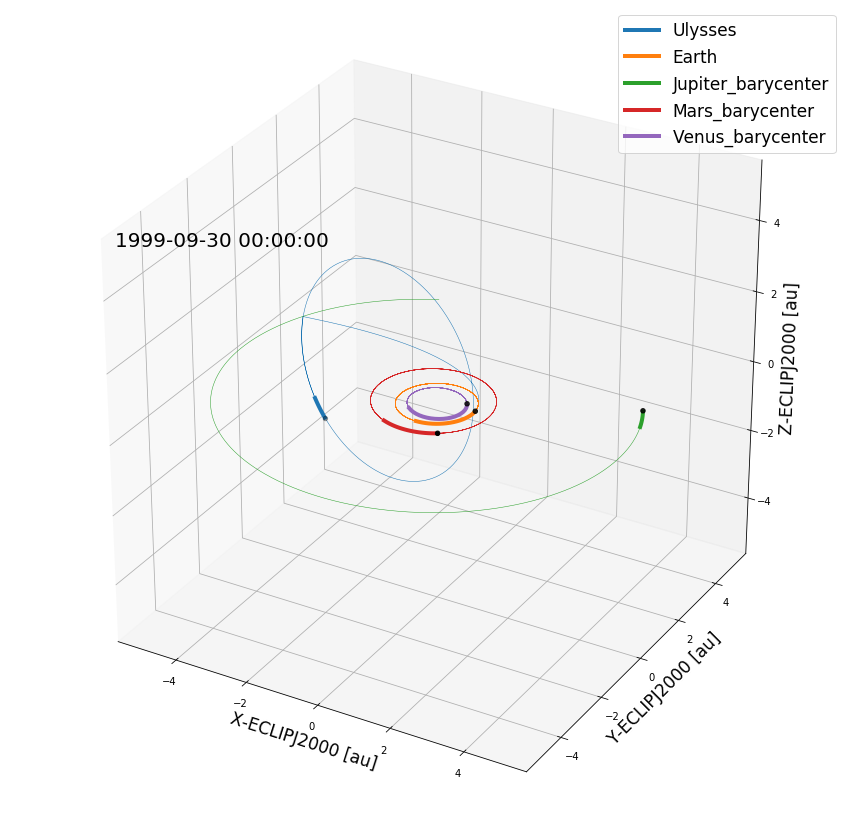

In [5]:
body_list = ['Ulysses',
             'Earth',
             'Jupiter_barycenter',
             'Mars_barycenter',
             'Venus_barycenter',
            ]
start = (1990, 10, 7)
end = (1999, 10, 7)
orbital_animations(body_list,start,end,fname='ulysses.mp4',t_delta=5.0)

## Helios 1 and  2 1976-1979

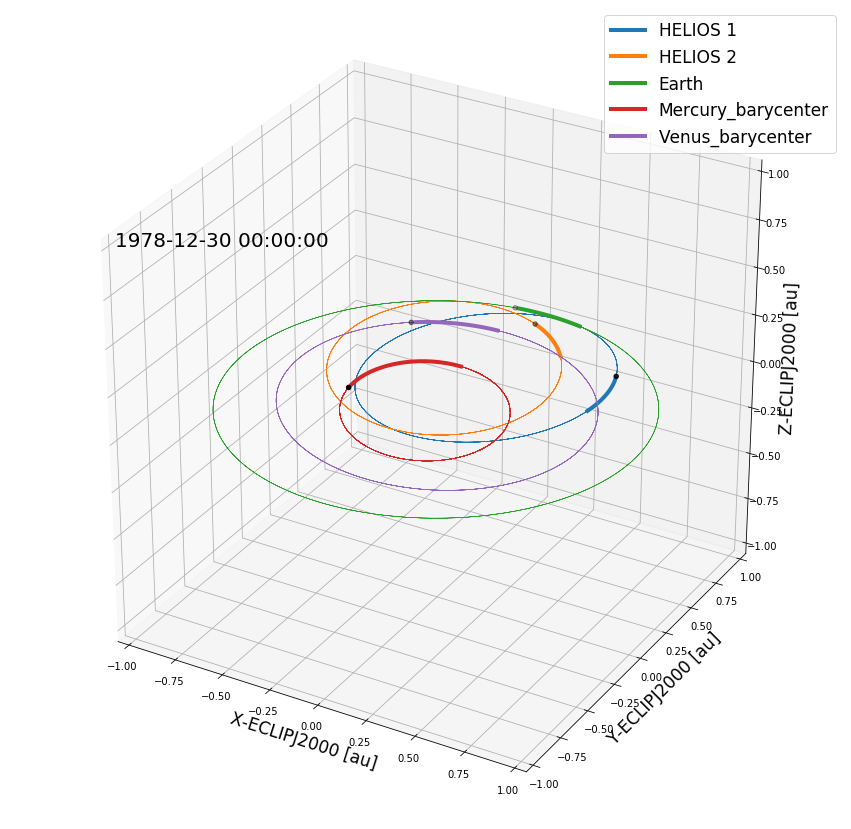

In [6]:
body_list = ['HELIOS 1',
             'HELIOS 2',
             'Earth',
             'Mercury_barycenter',
             'Venus_barycenter',
            ]
start=(1976, 1, 16) 
end=(1979, 1, 1)
orbital_animations(body_list,start,end,fname='helios.mp4')

## Parker Solar Probe

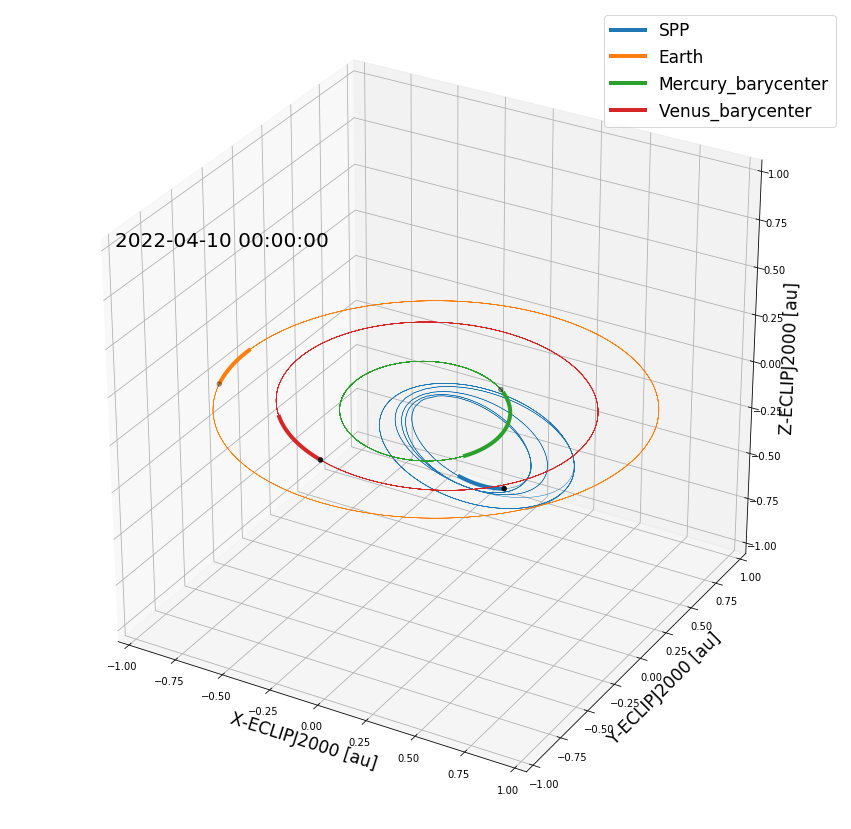

In [7]:
body_list = ['SPP',
             'Earth',
             'Mercury_barycenter',
             'Venus_barycenter',
            ]
start=(2018, 8, 17) 
end=(2022, 4, 12)
orbital_animations(body_list,start,end,fname='psp.mp4',fps=30)

## Juno 
### Part 2 : Polar Orbit Since July 2016

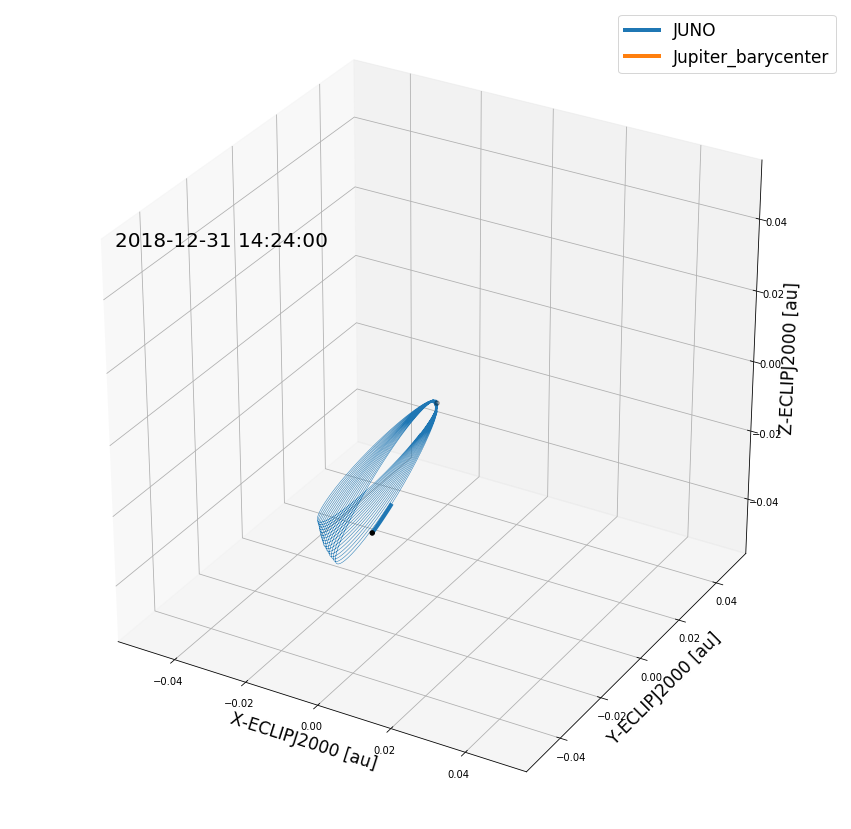

In [8]:
body_list = ['JUNO',
             'Jupiter_barycenter',
            ]
start=(2016, 7, 6) 
end=(2019, 1, 1)
orbital_animations(body_list,start,end,fname='juno.mp4',fps=30,SPICE_Origin='Jupiter_barycenter',
                  t_delta=0.2)

### STEREO A and B

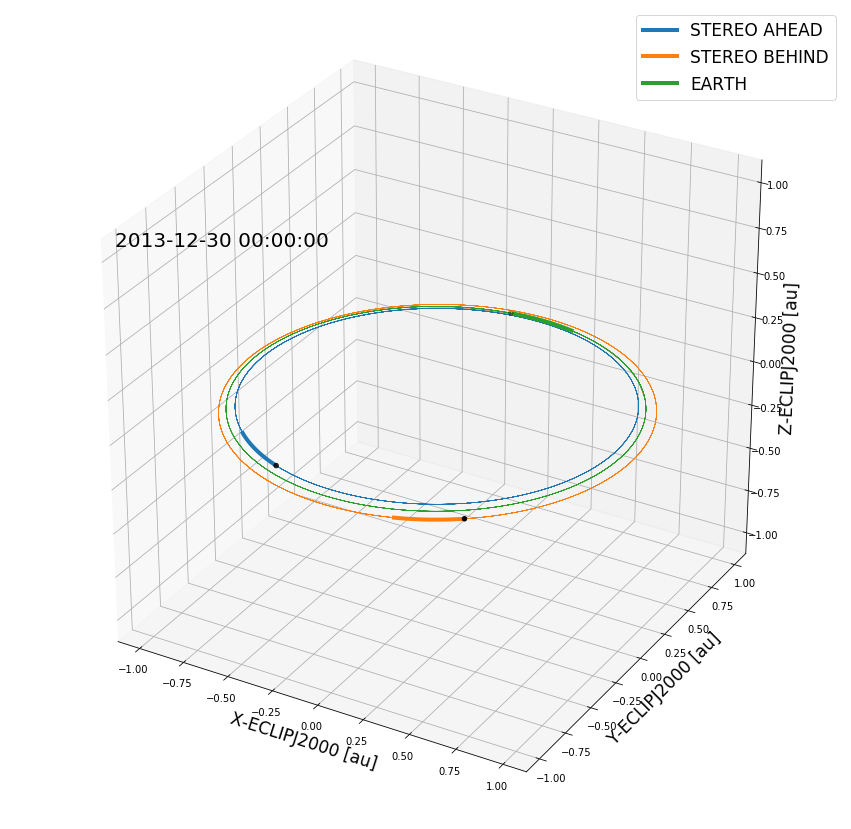

In [9]:
body_list = ['STEREO AHEAD',
             'STEREO BEHIND',
             'EARTH'
            ]
start=(2006, 10, 27) 
end=(2014, 1, 1)
orbital_animations(body_list,start,end,fname='stereo.mp4',
                   fps=30,
                   t_delta=1.0
                  )

### Solar Orbiter

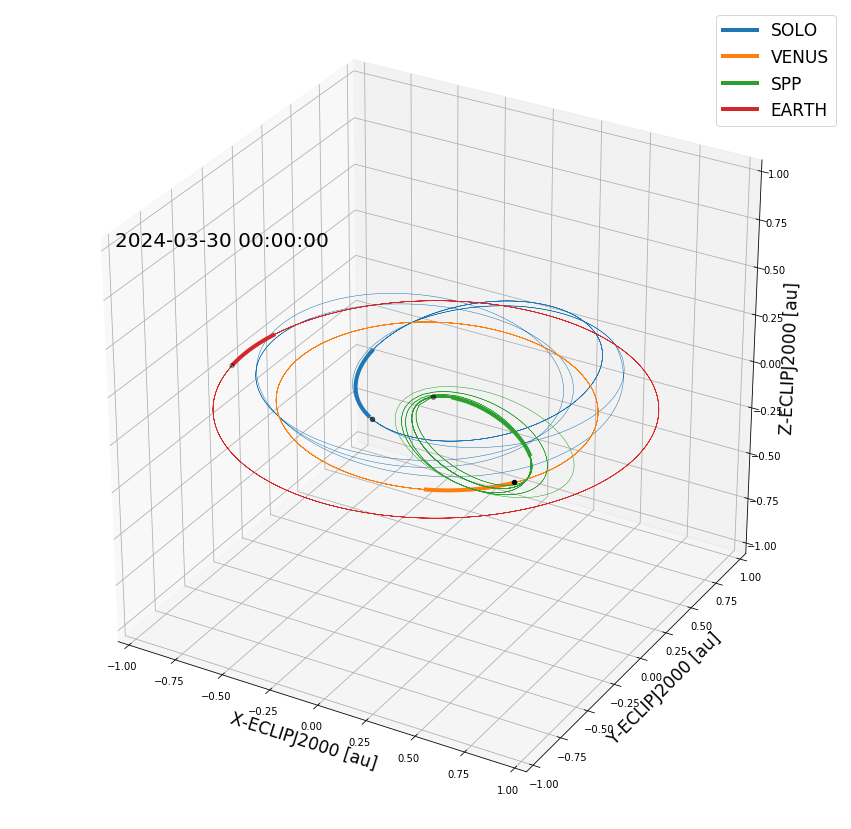

In [10]:
body_list = ['SOLO',
             'VENUS',
             'SPP',
             'EARTH',
            ]
start=(2020, 3, 1) 
end=(2024, 4, 1)
orbital_animations(body_list,start,end,fname='solar-orbiter.mp4',
                   fps=30,
                   t_delta=1.0
                  )

### Voyagers

### Voyager 1 and 2

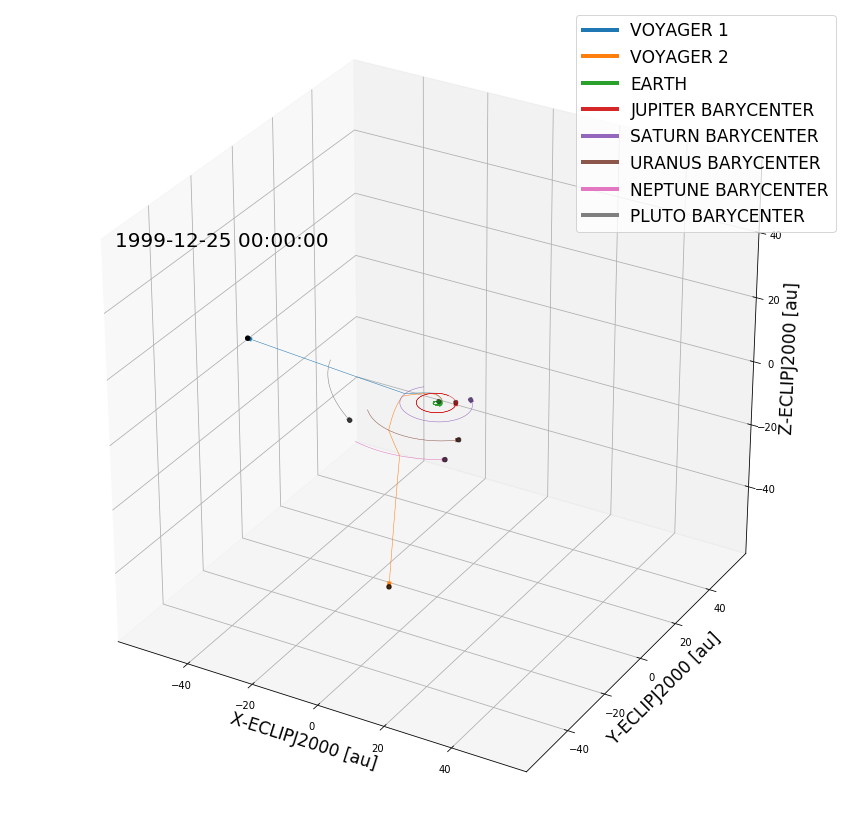

In [11]:
body_list = ['VOYAGER 1',
             'VOYAGER 2',
             'EARTH',
             'JUPITER BARYCENTER',
             'SATURN BARYCENTER',
             'URANUS BARYCENTER',
             'NEPTUNE BARYCENTER',
             'PLUTO BARYCENTER'
            ]
start=(1977, 10, 1) 
end=(2000, 1, 1)
orbital_animations(body_list,start,end,fname='vgr1&2.mp4',
                   fps=60,
                   t_delta=5.0
                  )